# One Step Forecasting of CO2 Levels with SARIMA Models

## Pre-processing the Data

In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

The data set that we use is the historic atmospheric ${\text{CO}}_2$ levels from continuous air samples at Mauna Loa Observatory, Hawaii, USA, collected between March 1958 to December 2001.

In [2]:
data = sm.datasets.co2.load_pandas()
co2_data = data.data
print(type(co2_data))
print(co2_data.head(10))

<class 'pandas.core.frame.DataFrame'>
              co2
1958-03-29  316.1
1958-04-05  317.3
1958-04-12  317.6
1958-04-19  317.5
1958-04-26  316.4
1958-05-03  316.9
1958-05-10    NaN
1958-05-17  317.5
1958-05-24  317.9
1958-05-31    NaN


Checking for `NaN` values, we see 59 missing values in the `Series` `co2`:

In [3]:
print(f'Number of entries = {len(co2_data)},\nNumber of null entries = {co2_data.isnull().sum()[0]}')

Number of entries = 2284,
Number of null entries = 59


We first resample into monthly data sets and fill in missing values by pulling back future values with `bfill()` (recall that `resample()` returns a `DatetimeIndexResampler` object and `mean()` returns a `Series` object; we need to construct a `DataFrame` from their chained output):

In [4]:
co2_data = pd.DataFrame(co2_data['co2'].resample('MS').mean())

# After resampling, we still have 5 missing values:
print(f'Number of missing enetries after resampling: {co2_data.isnull().sum()[0]}')

# bfill() and verify we no longer have any NaN values
co2_data = co2_data.fillna(co2_data.bfill())
print(f'Number of missing enetries after bfill: {co2_data.isnull().sum()[0]}')

Number of missing enetries after resampling: 5
Number of missing enetries after bfill: 0


We plot the raw data as a preliminary visualisation:

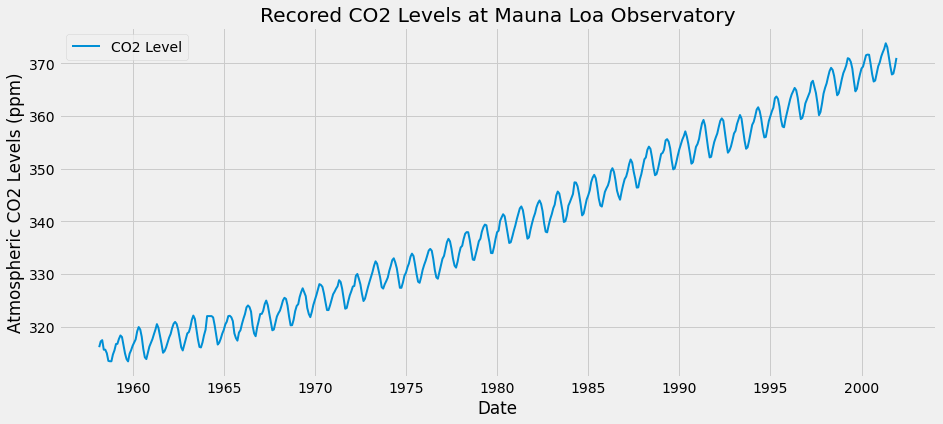

In [5]:
fig, ax = plt.subplots(figsize = (14,6))
ax.plot(co2_data['co2'], linewidth = 2, label = 'CO2 Level')
ax.set_title('Recored CO2 Levels at Mauna Loa Observatory')
ax.set_xlabel('Date')
ax.set_ylabel('Atmospheric CO2 Levels (ppm)')
ax.legend(loc = 'best')

We note an obvious seasonality and upward trend.

***

## The ARIMA Time Series Model

One of the most common methods used in time series forecasting is known as the ARIMA (__A__uto __R__egressive __I__ntegrated __M__oving __A__verage) model. It is a model in three parameters `(p,d,q)` that can be fitted to time series data to allow forecasting or better-understand furture points in the series.

The three parameters in an `ARIMA(p,d,q)` model accounts for seasonality, trends and noise in the data:
* `p` is the _autoregressive_ part of the model e.g. if the past three days have been warm, the next day is also likely to be warm.
* `d` is the _integrated_ part of the model concerned with differencing e.g. if the difference in temperatures for the past three days have been small, the next day is likely to be  a similar temperature.
* `q` is the _moving average_ part of the model that allows us to set the errors of the model as a linear combination of the errors values observed at previous points in time.

If the data exhibits obvious seasonal trends, as our dataset exhibits, it may be more appropriate to fit a SARIMA (__S__easonal ARIMA) model. We denote such models as `ARIMA(p,d,q)(P,D,Q)s` where the second set of parameters follow the same definitions as `(p,d,q)` but applied on seasonal scales. The trailing `s` is the periodicity of the time series; 4 for quarterly, 12 for yearly periods etc. In this project, we shall fit a yearly SARIMA model to the Mauna Loa $\text{CO}_2$ data and use it to generate one step ahead forecasts and compare its performance to historic data.

SARIMA modles thus have a lot of tunable paramaters. They are thus extremly versatile but it can be very difficult to find the optimal parameter set.

## Parameter Selection for the SARIMA model

Whilst some languages, such as R, provide an automated way of handling parameter selection these have yet to be ported to Python and so we resort to manual fitting of the parameters by a grid search. The only parameter we shall fix is the periodicity of the seasonality $s=12$ since the data exhibits an obvious yearly seasonality.

We iteratively explors possible combinations of the parameters, fit a new SARIMA model with the `SARIMAX()` function and assess its quality to pick out the optimum set of parameters within the chosen landscape of parameters.

In [6]:
# Seasonal periodicity
s = 12

# We allow each of p, d, q to take on any of the values in [0, 1].
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

# Generate all the possible parameter combinations (P,D,Q) for the seasonal component:
seasonal_pdq = list((x[0], x[1], x[2], s) for x in pdq)

SARIMA_params = itertools.product(pdq, seasonal_pdq)
print("Possible combinations of parameters for the SARIMA model:")
for i, j in SARIMA_params:
    print(f'\tSARIMA{i}{j}')

Possible combinations of parameters for the SARIMA model:
	SARIMA(0, 0, 0)(0, 0, 0, 12)
	SARIMA(0, 0, 0)(0, 0, 1, 12)
	SARIMA(0, 0, 0)(0, 1, 0, 12)
	SARIMA(0, 0, 0)(0, 1, 1, 12)
	SARIMA(0, 0, 0)(1, 0, 0, 12)
	SARIMA(0, 0, 0)(1, 0, 1, 12)
	SARIMA(0, 0, 0)(1, 1, 0, 12)
	SARIMA(0, 0, 0)(1, 1, 1, 12)
	SARIMA(0, 0, 1)(0, 0, 0, 12)
	SARIMA(0, 0, 1)(0, 0, 1, 12)
	SARIMA(0, 0, 1)(0, 1, 0, 12)
	SARIMA(0, 0, 1)(0, 1, 1, 12)
	SARIMA(0, 0, 1)(1, 0, 0, 12)
	SARIMA(0, 0, 1)(1, 0, 1, 12)
	SARIMA(0, 0, 1)(1, 1, 0, 12)
	SARIMA(0, 0, 1)(1, 1, 1, 12)
	SARIMA(0, 1, 0)(0, 0, 0, 12)
	SARIMA(0, 1, 0)(0, 0, 1, 12)
	SARIMA(0, 1, 0)(0, 1, 0, 12)
	SARIMA(0, 1, 0)(0, 1, 1, 12)
	SARIMA(0, 1, 0)(1, 0, 0, 12)
	SARIMA(0, 1, 0)(1, 0, 1, 12)
	SARIMA(0, 1, 0)(1, 1, 0, 12)
	SARIMA(0, 1, 0)(1, 1, 1, 12)
	SARIMA(0, 1, 1)(0, 0, 0, 12)
	SARIMA(0, 1, 1)(0, 0, 1, 12)
	SARIMA(0, 1, 1)(0, 1, 0, 12)
	SARIMA(0, 1, 1)(0, 1, 1, 12)
	SARIMA(0, 1, 1)(1, 0, 0, 12)
	SARIMA(0, 1, 1)(1, 0, 1, 12)
	SARIMA(0, 1, 1)(1, 1, 0, 12)
	SARIMA(0, 1

In order to evaluat the goodness of fit, we use the __AIC value__ (Akaike Infromation Criterion) which is reported with ARIMA models fitted with `statsmodels`. The AIC is a measure of how well the model fits the data, whilst taking into account the overall complexity of the model i.e. we prefer models that achieve the same goodness-of-fit whilst using fewer features. In particular, we prefer models that return the _lowest_ AIC value.

The following code performs a grid search over all of the possible SARIMA combinations we generated above, fits to the data and evaluates the AIC value of each model. Finally, it returns the parameter combination with the lowest AIC value.

In [7]:
# Some parameter combinations are not valid. Ignore warning messages
warnings.filterwarnings("ignore")

aic = {}

for params in pdq:
    for seasonal_params in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(co2_data, 
                                              order = params,
                                              seasonal_order = seasonal_params,
                                              enforce_stationaraity = False,
                                              enforce_invertibility = False)
            results = model.fit()
            aic.update({f'SARIMA{params}{seasonal_params}': results.aic})
            print(f'ARIMA{params}{seasonal_params}: AIC = {results.aic}')
        except:
            continue
print(aic)

minval = min(aic.values())
optimum = [(k, v) for k, v in aic.items() if v == minval]
# optimum is a list of length one, containing a tuple (aic, model)
print(f'\nLowest AIC = {optimum[0][1]} for model {optimum[0][0]}')

ARIMA(0, 0, 0)(0, 0, 0, 12): AIC = 7626.943594958338
ARIMA(0, 0, 0)(0, 0, 1, 12): AIC = 6957.288036271688
ARIMA(0, 0, 0)(0, 1, 0, 12): AIC = 1857.624339889968
ARIMA(0, 0, 0)(0, 1, 1, 12): AIC = 1634.6625982272858
ARIMA(0, 0, 0)(1, 0, 0, 12): AIC = 2057.255779233646
ARIMA(0, 0, 0)(1, 0, 1, 12): AIC = 1835.7966867018222
ARIMA(0, 0, 0)(1, 1, 0, 12): AIC = 1398.4561196922323
ARIMA(0, 0, 0)(1, 1, 1, 12): AIC = 1119.2721968234093
ARIMA(0, 0, 1)(0, 0, 0, 12): AIC = 6907.101966591662
ARIMA(0, 0, 1)(0, 0, 1, 12): AIC = 6236.105272306411
ARIMA(0, 0, 1)(0, 1, 0, 12): AIC = 1383.5838661636997
ARIMA(0, 0, 1)(0, 1, 1, 12): AIC = 1276.7784730240842
ARIMA(0, 0, 1)(1, 0, 0, 12): AIC = 1607.2228379626072
ARIMA(0, 0, 1)(1, 1, 0, 12): AIC = 1150.068960108588
ARIMA(0, 0, 1)(1, 1, 1, 12): AIC = 868.5667608534741
ARIMA(0, 1, 0)(0, 0, 0, 12): AIC = 1678.850182235887
ARIMA(0, 1, 0)(0, 0, 1, 12): AIC = 1271.6802658530646
ARIMA(0, 1, 0)(0, 1, 0, 12): AIC = 633.7998386712203
ARIMA(0, 1, 0)(0, 1, 1, 12): AIC = 386

In the above, we purposefully suprressed warnings at the beginning because some combinataions may lead to numerical issues that will pollute the output with warning messages. We catch any errors that they raise and ignore that parameter combination. The output of the code above suggest that the optimum combination of parameters in this parameter landscape is `SARIMA(1, 1, 1)(0, 1, 1, 12)`. We thus specify our model with these parameters:

In [8]:
model = sm.tsa.statespace.SARIMAX(co2_data,
                                  order = (1, 1, 1),
                                  seasonal_order = (0, 1, 1, 12),
                                  enforce_stationarity = False,
                                  enforce_invertibility = False)
result =  model.fit()

The function `sm.tsa.statespace.SARIMAX()` returns a `SARIMAX` object whilst `fit()` returns a `SARIMAXResultsWrapper`:

In [9]:
print(type(model))
print(type(result))

<class 'statsmodels.tsa.statespace.sarimax.SARIMAX'>
<class 'statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper'>


The `SARIMAXResultsWrapper.summary()` function returns a signifiant amount of information:

In [10]:
print(result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                co2   No. Observations:                  526
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -143.969
Date:                            Thu, 17 Sep 2020   AIC                            295.937
Time:                                    11:47:43   BIC                            312.788
Sample:                                03-01-1958   HQIC                           302.550
                                     - 12-01-2001                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3869      0.091      4.270      0.000       0.209       0.565
ma.L1         -0.6782      0.073   

We unpack each of these tables in turn.

In [11]:
print(result.summary().tables[0])

                                     SARIMAX Results                                      
Dep. Variable:                                co2   No. Observations:                  526
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -143.969
Date:                            Thu, 17 Sep 2020   AIC                            295.937
Time:                                    11:47:43   BIC                            312.788
Sample:                                03-01-1958   HQIC                           302.550
                                     - 12-01-2001                                         
Covariance Type:                              opg                                         


The left hand column is mostly self-explanatory except the `Covariance Type: opg`. This just denotes that the OPG estimator was used to compute the covariance matrix. The OPG (outer product of gradeints) estimator is a consistent estimate of the covariane matrix $\Sigma$ i.e. it converges to $\Sigma$ in probability.

On the right hand column, we see that the SARIMAX fits by a log-likelihood fit. The final three rows are different criteria for model selection. We have already seen AIC and, to it, we add the BIC (Bayesian information criterion) and HQIC (Hannan-Quinn information criterion) as alternative measures of fitness of a model. Whilst all three measures credit goodness-of-fit and penalise complexity of models the BIC, for example, introduces a heavier penalty for overfitting than the AIC. We could have chosen our model based on minimising the BIC instead.

In [12]:
print(result.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3869      0.091      4.270      0.000       0.209       0.565
ma.L1         -0.6782      0.073     -9.347      0.000      -0.820      -0.536
ma.S.L12      -0.8655      0.027    -32.198      0.000      -0.918      -0.813
sigma2         0.1023      0.005     21.950      0.000       0.093       0.111


The rows are the estimated features:

* `ar.L1` and `ma.L1` are the AR and MA variables lagged by 1 time step (since $p = q= 1$ in the model)
* `ma.S.L12` is the MA variables lagged by 12 times step (since $Q = 1$ and $s=12$). Note that there is no `ar.S.L12` since $P = 0$ in our model.

The `coef` column shows the estimates of the features in the left-most column and `std err` records the standard error of these estimates.

`z` is the z-statistic of the feature; a statistical test for which the null hypothesis is an underlyling (approximately) Gaussain distribution. Accordingly, `P>|z|` is the cCDF evaluated at $z$. Using a cut-off of $P < 0.05$ for statistical significance, we see that all four of the lagged $\text{AR}$ and $\text{MA}$ terms impact the forecast at that significance.

The final two columns give the range of values of the feature within 2se of the estimate.

In [13]:
print(result.summary().tables[2])

Ljung-Box (Q):                       35.26   Jarque-Bera (JB):               125.75
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                             0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.38


The Ljung-Box test is a statistical test applied to the _residuals_ of a fitted ARIMA model. It tests whether any group of autocorrelations of a time series differs from zero; a test of independence of the residuals. The test statistic is defined as

$$
Q = n(n+2) \sum_{k=1}^h \frac{\hat{\rho}_k^2}{n - k}\,,
$$

where $n$ is the sample size, $\hat{\rho}_k$ is the sample autocorrelation at lag $k$ and $h$ is the number of lags being tested. Under the null hypothesis $H_0$ that the residuals are independently distributed, $Q$ asymptotically follows a $\chi^2_h$ distribution.

The Jarque-Bera test is a goodness-of-fit test of whether the _residuals_ of the fit have the same skewness and kurtosis as a normal distribution null hypothesis. It is defined as

$$
\text{JB} = \frac{n}{6} \left( S^2 + \frac{1}{4} {(K - K_0)}^2 \right)\,,
$$

where $S$ and $K$ are the sample skewness and kurtosis and $K_0 = 3$ is the kurtosis of the Gaussian distribution (consequently, $K-3$ is the excess kurtosis). Asymptotically, the Jarque-Bera statistic asymptotically follows a $\chi_2^2$ distribution under the null hypothesis $H_0$ that the data is normally distributed.

The two-sidded heteroskedasticity test reported is a type of Goldfeld-Quandt test in which the sum-of-squares of the sample in the first third of the sample is tested for whether it differs from the sum-of-squares in the last third.

A more heuristic method of assessing the model is offered by `plot_diagnostics`:

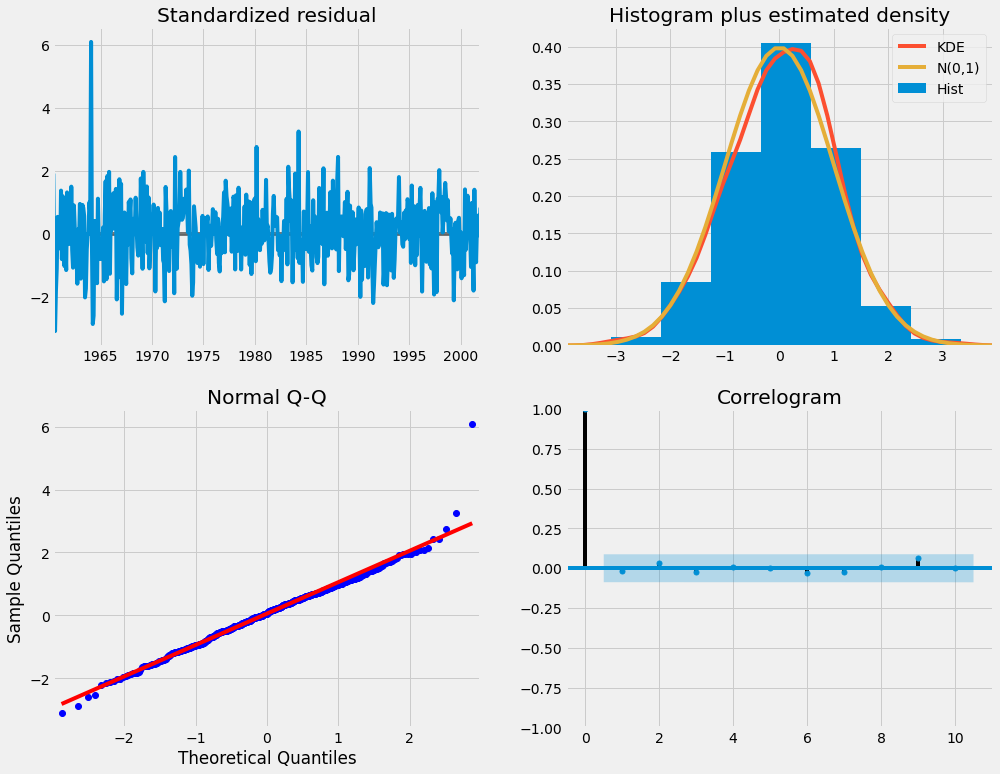

In [14]:
result.plot_diagnostics(figsize = (15, 12))
plt.show()

Our primary concer is whether the residuals of the model are uncorrelated and normally distributed. If they are not, it is a good indication that the ARIMA fit can be improved. Here, we see that these assumptions do hold and so the fit is good:
* The residuals over time in the top left plot show no obvious trends or seasonality and look like white noise. This is backed up the correlogram in the bottom right that shows no significant serial autocorrelation of the residuals.
* In the top right plot, the KDE line closely follows a $N(0,1)$ plot and so the residuals are approximately standard normally distributed;
* The Q-Q plot (quantile-quantile plot) in the bottom left compares the distribution of the quantiles of the residuals against those of a theoretical $N(0,1)$ distribution;

N.b. KDE = _kernel density estimation;_ a non-parametric estimation of the p.d.f. of an r.v. (here, the residuals).

In this context, the Ljung-Box and Jarque-Bera tests can be thought of as a quantitative summary of the top-left and top-right plots, since they respectively measure the randomness of the distribution of the reisduals and its similarity to a normal distribution (in particular, the skewness and kurtosis) respectively.

We thus conclude that these parameters give an adequate fit, although it could be improved by increasing the range of the grid search (at the expense of computation time).

***

## Forecasting and Validating Forecasts

We now have a model with which to produce forecasts. The commands that we shall focus on in this section are the `get_prediction()` and `conf_int()` functions. These give the values and confidence intervals for the forecast.

In [15]:
pred = result.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_ci = pred.conf_int()

We have used `pd.to_datetime` to convert the string into a a `DateTime` format that `pandas` can understand. In particular, we _start_ forecasting at 1st Jan. 1998. The `dynamic=False`argument ensures that only one-step predictions are made and that each forecast uses the _full_ history of the time series up to that point.

We now plot the forecasts against the actual data to assess how well the forecast worked.

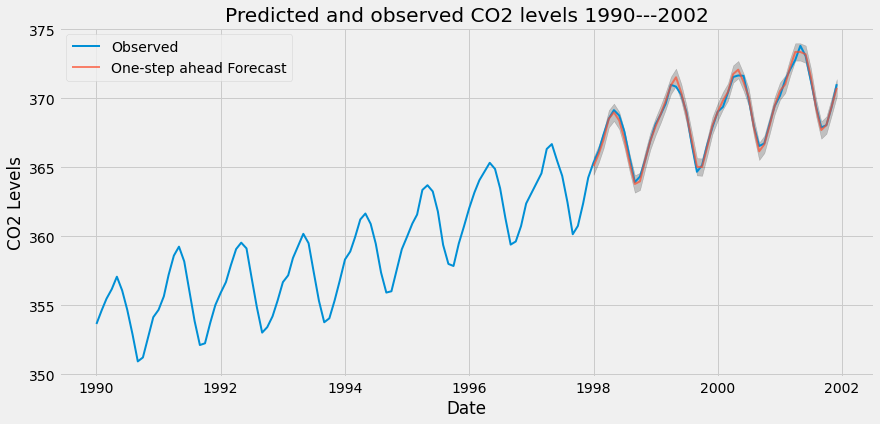

In [16]:
fig, ax = plt.subplots(figsize = (13,6))

# Plot all the features
ax.plot(co2_data['1990':], linewidth = 2, label = 'Observed')
ax.plot(pred.predicted_mean, linewidth = 2, label = 'One-step ahead Forecast', alpha = 0.7)

# Shade in the areas between y = pred_ci.iloc[:, 0] and y = pred_ci.iloc[:, 1], plotted
# against x = pred_ci.index. Set the color to black = 'k' with an alpha of 0.2.
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color = 'k', alpha = 0.2)

# Add Information
ax.set_title('Predicted and observed CO2 levels 1990---2002')
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

We see a very good fit of the predicted values to the observed values and a very tight confidence intervals; the model appears to predict well.

Note that we have sliced the `DataFrame` to start at 1990, rather than 1958 (where the data starts), to focus on the performance of the forecast.